# Compare the accelerometry measures of stillness
compare the ACC measure variability of many sensors in four intervals of measurement with three statistics. 

Sensors: 
 - Phone
 - AX3
 - Equivital
 - Movesense
 - Qualsys mocap
 - Video 
 
Statistics:
 - Average (std) QoM per second (cummulative normed acceleration difference/120s)
 - Average (std) QoM per sample (average normed acceleration difference)
 - Range of displacement (max of rectified difference from mean. Per dimension?)
 
Intervals:
 - Lying flat on the floor
 - Lying flat on a table
 - Standing still 1 
 - Standing still 2
 
 
 vector norm 
lying still conditions 
    (floor, table, standstill2, Stanstill1) 
steady deviance per second, 
per sample
rectified range: minus mean and rectified 
    


Clock differences


In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d

In [52]:
def min_dets(eq_file_loc): # for files output by the lab manager desktop app, so far
    filings = eq_file_loc.split('/')
    file_name = filings[-1]
    f = file_name.split('.')[0]
    dets = f.split('_')
    sensorType = dets[0]
    start_time= pd.to_datetime(dets[2],format = '%Y%m%dT%H%M%S%f')
    if sensorType in ['Equivital','Movesense']:
        start_time = start_time.tz_localize("UTC")
    if sensorType in ['Phone','AX3']:
        start_time = start_time.tz_localize("Europe/Berlin")
    if sensorType in ['Qualsys']:
        start_time = start_time.tz_localize("EET")
        
    df = pd.read_csv(eq_file_loc,index_col=0) 
    end_time= start_time+ pd.to_timedelta(df['Time'].iloc[-1],unit ='s')
    
    File_dets={'Signal':dets[1], #f[-2].split('_')[-1],
       'Sensor':sensorType, 
       'StartTime':start_time,
       'UTCstartTime':start_time.tz_convert("UTC"),
       'UTCendTime':end_time.tz_convert("UTC"),
       'FileName':file_name,
       'X' :df['X'].mean(),
       'Y' :df['Y'].mean(),
       'Z' :df['Z'].mean(),
       'FullLoc':eq_file_loc}
    return File_dets

In [53]:
path = './OUTFILES/'
file_locs = []
for root, dirs, files in os.walk(path):
    for file in files:
        if(file.lower().endswith(".csv")):
            file_locs.append(os.path.join(root,file))
            print(file_locs[-1])
k=[]           
for f in file_locs:
    if len(f.split('_'))==3:
        File_dets=min_dets(f)
        k.append(File_dets)
df_files=pd.DataFrame(data=k) #.sort_values('StartTime').reset_index(drop=True)
df_files

./OUTFILES/Movesense_ACC_20230203T120018000.csv
./OUTFILES/Equivital_ACC_20230131T143737039.csv
./OUTFILES/Qualsys_LOC_20230131T165515333.csv
./OUTFILES/AX3_ACC_20230131T154908485.csv
./OUTFILES/Phone_ACC_20230203T124637000.csv
./OUTFILES/Movesense_ACC_20230203T114458000.csv
./OUTFILES/AX3_ACC_20230203T124319505.csv
./OUTFILES/Movesense_ACC_20230131T145727000.csv
./OUTFILES/Phone_ACC_20230131T155837000.csv
./OUTFILES/Phone_ACC_20230203T130008000.csv
./OUTFILES/Equivital_ACC_20230203T113937039.csv


,Signal,Sensor,StartTime,UTCstartTime,UTCendTime,FileName,X,Y,Z,FullLoc
0,ACC,Movesense,2023-02-03 12:00:18+00:00,2023-02-03 12:00:18+00:00,2023-02-03 12:06:24.019000+00:00,Movesense_ACC_20230203T120018000.csv,-1.473418e-01,1.018045e-01,9.742499e+00,./OUTFILES/Movesense_ACC_20230203T120018000.csv
1,ACC,Equivital,2023-01-31 14:37:37.039000+00:00,2023-01-31 14:37:37.039000+00:00,2023-01-31 15:15:52.300000+00:00,Equivital_ACC_20230131T143737039.csv,6.950539e+01,-2.323754e+02,-8.915916e+02,./OUTFILES/Equivital_ACC_20230131T143737039.csv
2,LOC,Qualsys,2023-01-31 16:55:15.333000+02:00,2023-01-31 14:55:15.333000+00:00,2023-01-31 15:08:23.849669999+00:00,Qualsys_LOC_20230131T165515333.csv,4.137860e-18,-6.513452e-19,-1.123171e-18,./OUTFILES/Qualsys_LOC_20230131T165515333.csv
3,ACC,AX3,2023-01-31 15:49:08.485000+01:00,2023-01-31 14:49:08.485000+00:00,2023-01-31 15:13:38.979000+00:00,AX3_ACC_20230131T154908485.csv,1.242981e-01,7.596565e-01,-1.081613e-01,./OUTFILES/AX3_ACC_20230131T154908485.csv
4,ACC,Phone,2023-02-03 12:46:37+01:00,2023-02-03 11:46:37+00:00,2023-02-03 11:58:12.109734+00:00,Phone_ACC_20230203T124637000.csv,-9.900544e-01,5.531115e-02,-6.604025e-02,./OUTFILES/Phone_ACC_20230203T124637000.csv
5,ACC,Movesense,2023-02-03 11:44:58+00:00,2023-02-03 11:44:58+00:00,2023-02-03 11:59:09.338000+00:00,Movesense_ACC_20230203T114458000.csv,-8.791307e-02,-9.316953e+00,2.128527e+00,./OUTFILES/Movesense_ACC_20230203T114458000.csv
6,ACC,AX3,2023-02-03 12:43:19.505000+01:00,2023-02-03 11:43:19.505000+00:00,2023-02-03 12:09:49.964000+00:00,AX3_ACC_20230203T124319505.csv,7.494074e-02,-4.350857e-01,-3.974312e-01,./OUTFILES/AX3_ACC_20230203T124319505.csv
7,ACC,Movesense,2023-01-31 14:57:27+00:00,2023-01-31 14:57:27+00:00,2023-01-31 15:09:14.260000+00:00,Movesense_ACC_20230131T145727000.csv,2.331369e-01,9.262575e+00,3.632894e+00,./OUTFILES/Movesense_ACC_20230131T145727000.csv
8,ACC,Phone,2023-01-31 15:58:37+01:00,2023-01-31 14:58:37+00:00,2023-01-31 15:08:40.720062+00:00,Phone_ACC_20230131T155837000.csv,-9.949474e-01,7.638875e-02,-1.469619e-01,./OUTFILES/Phone_ACC_20230131T155837000.csv
9,ACC,Phone,2023-02-03 13:00:08+01:00,2023-02-03 12:00:08+00:00,2023-02-03 12:06:08.401004+00:00,Phone_ACC_20230203T130008000.csv,1.320820e-03,-5.855072e-03,1.005977e+00,./OUTFILES/Phone_ACC_20230203T130008000.csv


In [20]:
df_files['Sensor'].unique()

array(['Movesense', 'Equivital', 'Qualsys', 'AX3', 'Phone'], dtype=object)

In [299]:
Time_segments={'floor':['2023-02-03 12:01:00.000000+00:00', '2023-02-03 12:03:00.000000+00:00'],
    'table':['2023-02-03 12:04:00.000000+00:00', '2023-02-03 12:06:00.000000+00:00'],
    'standing1':['2023-01-31 15:00:00.000000+00:00','2023-01-31 15:02:00.000000+00:00'],
    'standing2':['2023-02-03 11:49:00.000000+00:00', '2023-02-03 11:51:00.000000+00:00']}

# '2023-01-31 15:00:00.000000+00:00','2023-01-31 15:02:00.000000+00:00'
# '2023-02-03 11:49:00.000000+00:00', '2023-02-03 11:51:00.000000+00:00'
# '2023-02-03 12:01:00.000000+00:00', '2023-02-03 12:03:00.000000+00:00'
# '2023-02-03 12:04:00.000000+00:00', '2023-02-03 12:06:00.000000+00:00'

In [22]:
Time_segments.keys()

dict_keys(['floor', 'table', 'standing2', 'standing1'])

# Evaluate the gravity offset for each ACC


In [153]:
condition = 'standing1'
time_int=Time_segments[condition]
s_time = pd.to_datetime(time_int[0])
e_time = pd.to_datetime(time_int[1])
[s_time,e_time]

[Timestamp('2023-01-31 15:00:00+0000', tz='UTC'),
 Timestamp('2023-01-31 15:02:00+0000', tz='UTC')]

In [154]:
seg_sens = {}
for i,row in df_files.iterrows():
    if row['UTCstartTime']<s_time and row['UTCendTime']>e_time:
        start_time = row['StartTime'].tz_convert("UTC")
        
        df = pd.read_csv(row['FullLoc'],index_col=0)
        df['DateTime'] = start_time + pd.to_timedelta(df['Time'],unit ='s')
        df.set_index(df['DateTime'],inplace=True,drop=True)        
        cols = df.columns
        
        X = df.loc[df.index>s_time,:].copy()
        X = X.loc[X.index<e_time,:].copy()
        seg_sens[row['Sensor']] = X.loc[:,['X', 'Y', 'Z']].copy()

,Signal,Hz,X,Y,Z,g
0,AX3,200.843543,0.157848,0.967504,-0.179479,0.996666
1,Equivital,25.600328,132.578451,-175.430990,-948.513672,973.699202
2,Movesense,210.570646,0.271214,9.219330,3.749066,9.958211
3,Phone,16.670001,-0.999470,0.079727,-0.139344,1.012328


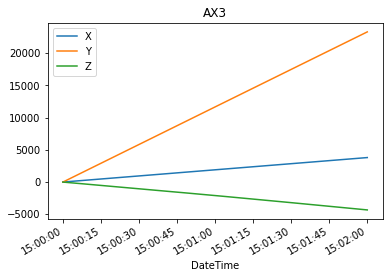

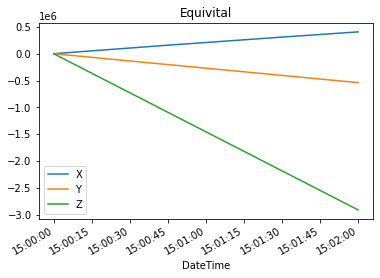

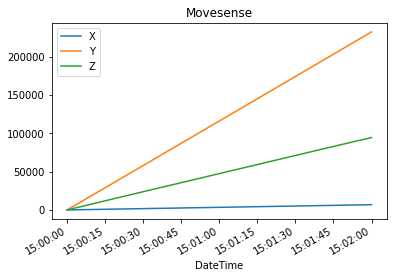

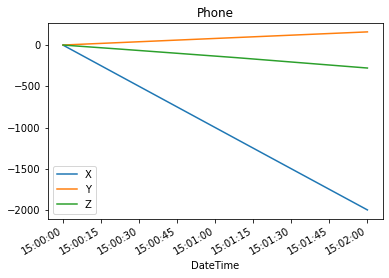

In [155]:
k=[]           

for sensor in ['AX3','Equivital', 'Movesense', 'Phone']:
    clip = seg_sens[sensor]
    qom = np.sqrt(np.square(clip - clip.mean()).sum(axis=1))
    seg_dets={'Signal':sensor,
              'Hz':1/pd.Series(clip.index).diff().mean().total_seconds(),
              'X' :clip['X'].mean(),
              'Y' :clip['Y'].mean(),
              'Z' :clip['Z'].mean(),
              'g': np.sqrt(np.square(clip).sum(axis=1)).mean(),
             }
    clip.cumsum().plot()
    plt.title(sensor)
    k.append(seg_dets)
plt.legend()
              
df_segStats=pd.DataFrame(data=k) #.sort_values('StartTime').reset_index(drop=True)
df_segStats

In [156]:
print(df_segStats.to_latex())

\begin{tabular}{llrrrrr}
\toprule
{} &     Signal &          Hz &           X &           Y &           Z &           g \\
\midrule
0 &        AX3 &  200.843543 &    0.157848 &    0.967504 &   -0.179479 &    0.996666 \\
1 &  Equivital &   25.600328 &  132.578451 & -175.430990 & -948.513672 &  973.699202 \\
2 &  Movesense &  210.570646 &    0.271214 &    9.219330 &    3.749066 &    9.958211 \\
3 &      Phone &   16.670001 &   -0.999470 &    0.079727 &   -0.139344 &    1.012328 \\
\bottomrule
\end{tabular}



The four accelerometers report values in different scales. To get a check on the different scales, we calculate the average total acceleration in the floor recording in each device's reported units. In this condition, the main force acting on each device is gravity. No matter the orientation of the device, the norm of acceleration should equal g, which at 60 degrees near sea level should be about 9.818 m/s^2. 

AX3 and Phone appear to normalise the recorded values to g, giving average acceleration of 1, or nearly.

Movesense has g very near the metric units of 9.818 m/s^2. Equivital seemss to have a value close to g but with a factor of 100 to scale acceleration to vary meaningfully within the discrete integer range of +/- 1024 (or similar value).  

To make these measurements comparable to other systems, we take normalise the acceleration measurements to actual g for this location. 

In [251]:
# from the floor measurements get estimate of gravity constant in the devices units
# The acceleration of gravity in Canada at latitude 60 degrees is approximately 9.818 m/s2, oslo is near 60
# this is used to linearly scale all the clips. 
grav = 9.818 # m/s^2
correction_factor = {'Movesense':9.743707, 'Equivital':976.849969, 'Qualsys':grav*1000, 'AX3':1.010485, 'Phone':1.006048}

# Can we reach comparable ACC measumrements from the qualsys data?
Qalsys reports position, could derive to acceleration
However, as this is calculated on noise rather than continuous signal, there is no continuity supporting the numerical calculations of teh derivative. It basically just explodes with discontinuities. 


In [288]:
def derv(values,times,n):
    if n == 0:
        s = pd.Series(data = values)
    if n> 0:
        v = derv(values,times,n-1)
        dt = times.diff()
        dv = v.diff()
        s = pd.Series(data = (dv/dt)) # this is terrible on sensor noise
    return s
        

In [153]:
condition = 'standing1'
time_int=Time_segments[condition]
s_time = pd.to_datetime(time_int[0])
e_time = pd.to_datetime(time_int[1])
[s_time,e_time]

[Timestamp('2023-01-31 15:00:00+0000', tz='UTC'),
 Timestamp('2023-01-31 15:02:00+0000', tz='UTC')]

In [ ]:
seg_sens = {}
for i,row in df_files.iterrows():
    if row['UTCstartTime']<s_time and row['UTCendTime']>e_time:
        start_time = row['StartTime'].tz_convert("UTC")
        
        df = pd.read_csv(row['FullLoc'],index_col=0)
        df['DateTime'] = start_time + pd.to_timedelta(df['Time'],unit ='s')
        df['Timestep'] = df['Time'].diff()
        df.set_index(df['DateTime'],inplace=True,drop=True)        
        cols = df.columns
        
        X = df.loc[df.index>s_time,:].copy()
        X = X.loc[X.index<e_time,:].copy()
        Y = grav* X.loc[:,['X', 'Y', 'Z']].copy()/correction_factor[row['Sensor']]
        Y['Disp'] = np.sqrt(np.square(Y.diff()).sum(axis=1))
        Y['Time'] = X['Time']
        Y['Timestep'] = X['Timestep']
        Y['jerk'] = Y['Disp']/Y['Timestep']
        seg_sens[row['Sensor']] = Y.copy()

In [289]:
clip = seg_sens['Qualsys']
clip

,X,Y,Z,Disp,Time,Timestep,jerk
DateTime,,,,,,,
2023-01-31 15:00:00.003830+00:00,0.000012,0.000044,0.000076,0.000000,284.67083,0.00416,0.000000
2023-01-31 15:00:00.008000+00:00,-0.000013,-0.000032,-0.000102,0.000195,284.67500,0.00417,0.046799
2023-01-31 15:00:00.012170+00:00,-0.000022,0.000022,0.000059,0.000170,284.67917,0.00417,0.040780
2023-01-31 15:00:00.016330+00:00,0.000036,-0.000021,-0.000002,0.000095,284.68333,0.00416,0.022721
2023-01-31 15:00:00.020500+00:00,-0.000073,-0.000014,-0.000026,0.000112,284.68750,0.00417,0.026818
...,...,...,...,...,...,...,...
2023-01-31 15:01:59.983000+00:00,0.000005,-0.000022,-0.000032,0.000039,404.65000,0.00417,0.009331
2023-01-31 15:01:59.987170+00:00,-0.000047,-0.000015,0.000060,0.000106,404.65417,0.00417,0.025398
2023-01-31 15:01:59.991330+00:00,0.000078,0.000011,0.000030,0.000131,404.65833,0.00416,0.031527


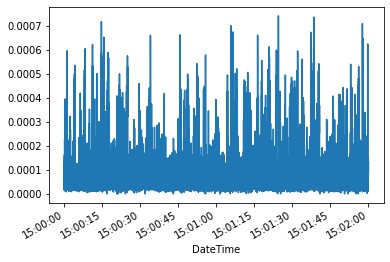

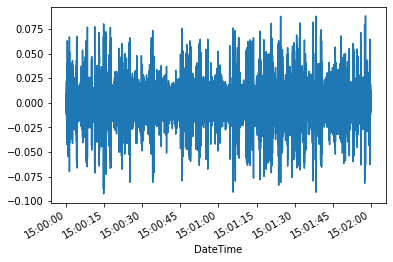

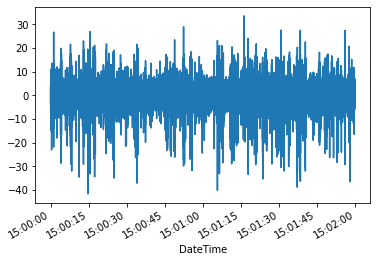

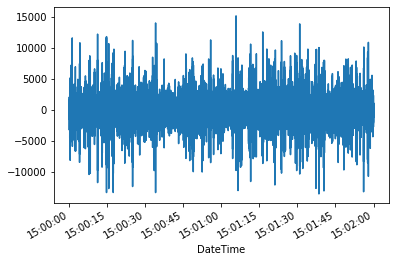

In [290]:
# (clip['Timestep'],  ddf = (0.339596 - 2*0.367879 + 0.398519)/(dx*dx)
values = np.sqrt(np.square(clip.loc[:,['X','Y','Z']]).sum(axis=1))
times = clip['Time']
for n in range(4): #n = 0
    ds = derv(values,times,n)
    ds.plot()
    plt.show()
    

That's all nonenses amplified. So no use trying to match the values that way. 



# Evaluate noise in accelerometer measurements, relative to gravity


In [294]:
seg_sens = {}
for i,row in df_files.iterrows():
    if row['UTCstartTime']<s_time and row['UTCendTime']>e_time:
        start_time = row['StartTime'].tz_convert("UTC")
        
        df = pd.read_csv(row['FullLoc'],index_col=0)
        df['DateTime'] = start_time + pd.to_timedelta(df['Time'],unit ='s')
        df['Timestep'] = df['Time'].diff()
        df.set_index(df['DateTime'],inplace=True,drop=True)        
        cols = df.columns
        
        X = df.loc[df.index>s_time,:].copy()
        X = X.loc[X.index<e_time,:].copy()
        Y = grav* X.loc[:,['X', 'Y', 'Z']].copy()/correction_factor[row['Sensor']]
        Y['Disp'] = np.sqrt(np.square(Y.diff()).sum(axis=1))
        Y['Time'] = X['Time']
        Y['Timestep'] = X['Timestep']
        Y['jerk'] = Y['Disp']/Y['Timestep']
        seg_sens[row['Sensor']] = Y.copy()
        

,Signal,Hz,X,Y,Z,g
0,AX3,200.806694,1.533669,9.400388,-1.743844,9.683731
1,Equivital,25.600000,1.332503,-1.763200,-9.533201,9.786333
2,Movesense,210.526754,0.273282,9.289624,3.777651,10.034140
3,Phone,16.669529,-9.753807,0.778057,-1.359855,9.879284


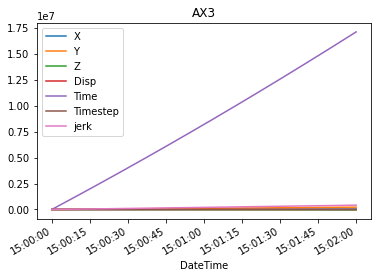

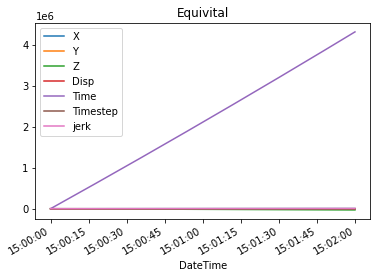

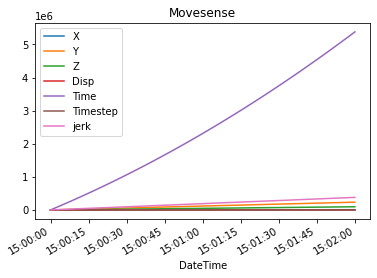

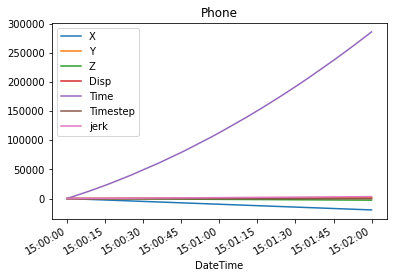

In [295]:
k=[]           

for sensor in ['AX3','Equivital', 'Movesense', 'Phone']:
    clip = seg_sens[sensor]
    seg_dets={'Signal':sensor,
              'Hz':1/clip['Timestep'].mean(),
              'X' :clip['X'].mean(),
              'Y' :clip['Y'].mean(),
              'Z' :clip['Z'].mean(),
              'g': np.sqrt(np.square(clip.loc[:,['X','Y','Z']]).sum(axis=1)).mean(),
             }
    clip.cumsum().plot()
    plt.title(sensor)
    k.append(seg_dets)
plt.legend()
              
df_segStats=pd.DataFrame(data=k) #.sort_values('StartTime').reset_index(drop=True)
df_segStats

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

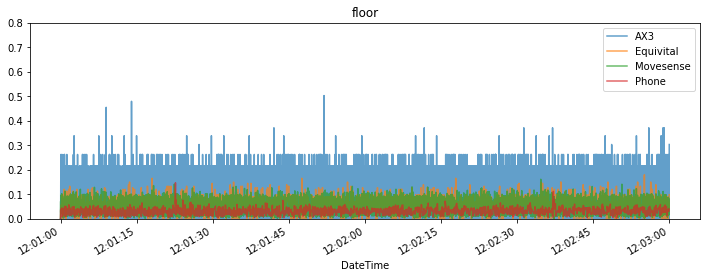

      Signal          Hz  QoM Mean   QoM STD   QoM Max      Dis Sec
0        AX3  200.000000  0.124412  0.083671  0.503512  3147.367068
1  Equivital   25.641026  0.063542  0.029095  0.179792    18.965060
2  Movesense  200.000000  0.047459  0.020184  0.161673   930.425866
3      Phone   25.269755  0.030789  0.012235  0.147309    15.058424


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

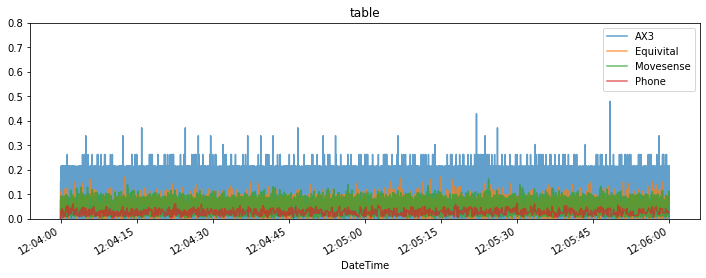

      Signal          Hz  QoM Mean   QoM STD   QoM Max      Dis Sec
0        AX3  200.000000  0.093700  0.084891  0.480080  2944.232649
1  Equivital   25.641026  0.062031  0.029266  0.170566    18.824349
2  Movesense  200.000000  0.047037  0.019955  0.163069   924.279562
3      Phone   18.057712  0.026791  0.010765  0.063711     8.631578


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

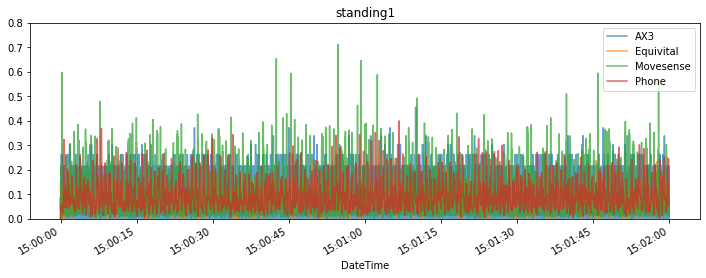

      Signal          Hz  QoM Mean   QoM STD   QoM Max      Dis Sec
0        AX3  200.000000  0.084978  0.086235  0.455443  2962.398929
1  Equivital   25.641026  0.078871  0.036948  0.238055    22.185139
2  Movesense  200.000000  0.070434  0.052668  0.712891  1554.540251
3      Phone   16.668889  0.098587  0.065381  0.399886    13.638536


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

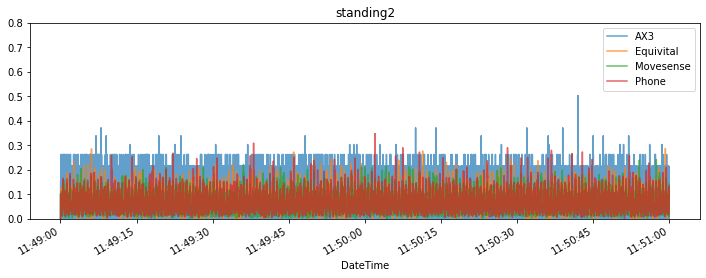

      Signal          Hz  QoM Mean   QoM STD   QoM Max      Dis Sec
0        AX3  200.000000  0.103042  0.087160  0.503512  2984.075604
1  Equivital   25.641026  0.087724  0.045040  0.287281    24.814288
2  Movesense  200.000000  0.058584  0.029611  0.241465  1228.840825
3      Phone   49.857905  0.066117  0.042737  0.348231    90.269844


In [300]:
for condition in Time_segments.keys():
    time_int=Time_segments[condition]
    s_time = pd.to_datetime(time_int[0])
    e_time = pd.to_datetime(time_int[1])

    seg_sens = {}
    for i,row in df_files.iterrows():
        if row['UTCstartTime']<s_time and row['UTCendTime']>e_time:
            start_time = row['StartTime'].tz_convert("UTC")
            df = pd.read_csv(row['FullLoc'],index_col=0)
            df['DateTime'] = start_time + pd.to_timedelta(df['Time'],unit ='s')
            df['Timestep'] = df['Time'].diff()
            df.set_index(df['DateTime'],inplace=True,drop=True)        
            cols = df.columns

            X = df.loc[df.index>s_time,:].copy()
            X = X.loc[X.index<e_time,:].copy()
            Y = grav* X.loc[:,['X', 'Y', 'Z']].copy()/correction_factor[row['Sensor']]
            Y['Disp'] = np.sqrt(np.square(Y.diff()).sum(axis=1))
            Y['Time'] = X['Time']
            Y['Timestep'] = X['Timestep']
            Y['jerk'] = Y['Disp']/Y['Timestep']
            seg_sens[row['Sensor']] = Y.copy()

    k=[]
    fig = plt.figure(figsize=(12,4))
    for sensor in ['AX3','Equivital','Movesense','Phone']: #,'Qualsys' seg_sens.keys():
        clip = seg_sens[sensor]
        #qom = np.sqrt(np.square(clip - clip.mean()).sum(axis=1))
        qom = np.sqrt(np.square(clip.loc[:,['X', 'Y', 'Z']].diff()).sum(axis=1))#/clip['Timestep']
        if sensor == 'Qualsys':
            qom = np.sqrt(np.square(clip.diff().diff().diff()).sum(axis=1))
        seg_dets={'Signal':sensor,
                  'Hz':1/pd.Series(clip.index).diff().median().total_seconds(),
                  'QoM Mean': qom.mean(),
                  'QoM STD': qom.std(),
                  'QoM Max': qom.max(), #np.sqrt(np.square(clip - clip.mean()).sum(axis=1)).max(),
                  'Dis Sec':np.sqrt(np.square(clip.diff()).sum(axis=1)).sum()/120,
                 }
        qom.plot(alpha = 0.7,label=sensor)
        #clip['Z'].plot(label=sensor)
        
        k.append(seg_dets)
    plt.legend()
    plt.title(condition)
    plt.ylim([0,0.8])
    plt.savefig('./plots/'+condition+'_standardized_qom.eps',format = 'eps',bbox_inches = 'tight',dpi = 300)
    plt.show()
    
    df_segStats=pd.DataFrame(data=k) #.sort_values('StartTime').reset_index(drop=True)
    print(df_segStats)

Surprising results:

1. The phone's sample rate changes per measurement interval. 
2. After unite normalisation, the AX3's have the largest samplewise noise and the phone has the least.
3. Respiration looks like it's coming through the Movesense when worn this way while standing. sometimes. 
4. The distance per second metric is overwhelmed by the samerate differences, so not worth holding onto right now when we have a lot of noise per sample. 

# Summary of samplewise noise in accelerometers


In [301]:
df_stats = pd.DataFrame(index = ['AX3','Equivital', 'Movesense', 'Phone'],columns = ['floor','table','standing1','standing2'])

for condition in Time_segments.keys():
    time_int=Time_segments[condition]
    s_time = pd.to_datetime(time_int[0])
    e_time = pd.to_datetime(time_int[1])

    seg_sens = {}
    for i,row in df_files.iterrows():
        if row['UTCstartTime']<s_time and row['UTCendTime']>e_time:
            start_time = row['StartTime'].tz_convert("UTC")
            df = pd.read_csv(row['FullLoc'],index_col=0)
            df['DateTime'] = start_time + pd.to_timedelta(df['Time'],unit ='s')
            df.set_index(df['DateTime'],inplace=True,drop=True)        
            cols = df.columns
            X = df.loc[df.index>s_time,:].copy()
            X = X.loc[X.index<e_time,:].copy()
            clip = grav* X.loc[:,['X', 'Y', 'Z']].copy()/correction_factor[row['Sensor']]
            qom = np.sqrt(np.square(clip.diff()).sum(axis=1)) #np.sqrt(np.square(clip - clip.mean()).sum(axis=1))
            st = qom.mean()
            
            df_stats.loc[row['Sensor'],condition] = str(np.round(qom.mean(),3)) + ' ('+str(np.round(qom.std(),3))+', Mx '+str(np.round(qom.max(),2))+')'

df_stats

,floor,table,standing1,standing2
AX3,"0.124 (0.084, Mx 0.5)","0.094 (0.085, Mx 0.48)","0.085 (0.086, Mx 0.46)","0.103 (0.087, Mx 0.5)"
Equivital,"0.064 (0.029, Mx 0.18)","0.062 (0.029, Mx 0.17)","0.079 (0.037, Mx 0.24)","0.088 (0.045, Mx 0.29)"
Movesense,"0.047 (0.02, Mx 0.16)","0.047 (0.02, Mx 0.16)","0.07 (0.053, Mx 0.71)","0.059 (0.03, Mx 0.24)"
Phone,"0.031 (0.012, Mx 0.15)","0.027 (0.011, Mx 0.06)","0.099 (0.065, Mx 0.4)","0.066 (0.043, Mx 0.35)"
Qualsys,NaN,NaN,"0.0 (0.0, Mx 0.0)",NaN


In [302]:
print(df_stats.to_latex())

\begin{tabular}{lllll}
\toprule
{} &                   floor &                   table &               standing1 &               standing2 \\
\midrule
AX3       &   0.124 (0.084, Mx 0.5) &  0.094 (0.085, Mx 0.48) &  0.085 (0.086, Mx 0.46) &   0.103 (0.087, Mx 0.5) \\
Equivital &  0.064 (0.029, Mx 0.18) &  0.062 (0.029, Mx 0.17) &  0.079 (0.037, Mx 0.24) &  0.088 (0.045, Mx 0.29) \\
Movesense &   0.047 (0.02, Mx 0.16) &   0.047 (0.02, Mx 0.16) &   0.07 (0.053, Mx 0.71) &   0.059 (0.03, Mx 0.24) \\
Phone     &  0.031 (0.012, Mx 0.15) &  0.027 (0.011, Mx 0.06) &   0.099 (0.065, Mx 0.4) &  0.066 (0.043, Mx 0.35) \\
Qualsys   &                     NaN &                     NaN &       0.0 (0.0, Mx 0.0) &                     NaN \\
\bottomrule
\end{tabular}



In [83]:
df_stats.columns

MultiIndex([(    'floor',),
            (    'table',),
            ('standing2',),
            ('standing1',)],
           )